# Consider heterogeneous model

Pick population susceptibilities from a gamma distribution with mean 1 and specified variance.

TH: 7 July 2023, trying to run 1e7 and incorporate parallel (M1 ultra should have 16+4 cores)


In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from time import time as timer

In [2]:
beta = 2/7 # 3/7, 1.5/10
gamma = 1/7 # 1/7, 1/10 
Reff = beta/gamma # Effective reproduction number


omega = beta + gamma # Average lifetime of infectious case
r = beta - gamma # Growth rate 
rho = omega


ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]

# Initial conditions for probability of extinction and moment equations

q0 = 0
m0 = 1
m2_0 = 1

# Colour map

cmap = sns.color_palette("Set2")


In [3]:
distvar = 2. # Pick other values here too
gd = st.gamma(a=1./distvar, loc=0., scale=distvar)
gd.stats()

(array(1.), array(2.))

In [4]:
def gillespie_peak_time(beta, gamma, y0, sigdist, nevents = int(2e5), N = int(1e5)):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones((nevents, 2))
    cases[0, 1] = y0
    cases[0, 0] = N-y0
    time = [0]
    e=0
    inftot = 0 #keep track of total infections
    sigvec = sigdist.rvs(size=N)
    sigvecsort = np.random.choice(
        a = sigvec,
        size = len(sigvec),
        replace = False,
        p = sigvec/np.sum(sigvec),
    )    
    sigmean = np.mean(sigvecsort[inftot:])
    
    while cases[e, 1]>0:
        e+=1
        rate_vec = np.array((beta*sigmean*cases[e-1, 1]*cases[e-1, 0]/N, gamma*cases[e-1, 1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        t += dt
        
        time.append(t)
        event_rand = rate_sum * rands[e, 1]
        try:
            event = np.where(rate_cumsum >= event_rand)[0][0]
        except:
            print(e, cases[0, :], rate_sum)
            return cases
        if event ==0:
            cases[e, 1] = cases[e-1, 1] + 1
            cases[e, 0] = cases[e-1, 0] - 1
            inftot += 1
            sigmean = np.mean(sigvecsort[inftot:])
        elif event == 1:
            cases[e, 1] = cases[e-1, 1] - 1
            cases[e, 0] = cases[e-1, 0]
    
    cases[e:, 0] = cases[e, 0]
    cases[e:, 1] = 0
    peak_size = np.max(cases[:, 1])
    peak_idx = np.argmax(cases[:, 1])
    peak_time = time[peak_idx]
    #return cases
    if peak_size >= N/1000:
        return peak_time, peak_size
    else:
        return 0., 0.

In [5]:
# Simulate peak times - parallelised
np.random.seed(123)
nruns_peak = 1000
population = int(1e7)

start = timer()
peaks = Parallel(n_jobs=-1)(
    delayed(gillespie_peak_time)(
        beta, 
        gamma, 
        y0 = 1, 
        sigdist=gd, 
        N = population, 
        nevents =2*population,
    ) for i in range(nruns_peak))

print("Executed in " + str(timer()-start) + ' seconds')

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Executed in 559336.3036952019 seconds


In [6]:
peak_times = pd.DataFrame(np.array([pt for (pt, ps) in peaks]))
peak_times.columns = ["PeakTime"]

       PeakTime
0     94.472766
1      0.000000
2      0.000000
3      0.000000
4      0.000000
..          ...
995  109.758290
996  101.095886
997   99.150140
998  111.560231
999    0.000000

[1000 rows x 1 columns]


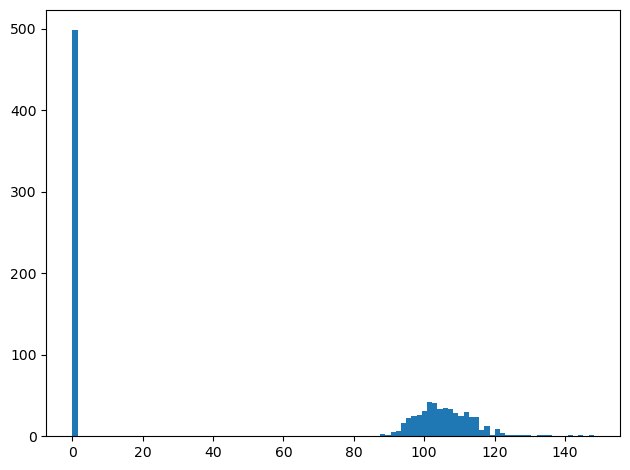

In [7]:
print(peak_times)
plt.hist(peak_times,100)
plt.tight_layout()

In [8]:
peak_times.to_csv("peak_times_heterogeneity_R=" + str(Reff) + "_nruns=" + str(nruns_peak) + "_pop=" + str(population) + ".csv")